<a href="https://colab.research.google.com/github/LysanetsAndriy/SluchMusic/blob/master/GTZAN_Genre_87_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install librosa matplotlib tensorflow keras


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
# Path to the dataset on Google Drive
dataset_path = '/content/drive/MyDrive/GTZAN/Data/genres_original'

# Configuration
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_components = dirpath.split("/")
            semantic_label = dirpath_components[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                try:
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                except Exception as e:
                    print(f"Could not process file {file_path}: {e}")
                    continue

                for s in range(num_segments):
                    start_sample = samples_per_segment * s
                    finish_sample = start_sample + samples_per_segment

                    mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                                sr=sr,
                                                n_fft=n_fft,
                                                n_mfcc=n_mfcc,
                                                hop_length=hop_length)
                    mfcc = mfcc.T

                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print(f"{file_path}, segment: {s+1}")

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

json_path = "/content/drive/MyDrive/GTZAN/data.json"
save_mfcc(dataset_path, json_path, num_segments=10)


In [ ]:
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

X, y = load_data(json_path)
X = X[..., np.newaxis]  # Add a new axis for CNN


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    MaxPool2D((2, 2), strides=(2, 2), padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    MaxPool2D((2, 2), strides=(2, 2), padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    MaxPool2D((2, 2), strides=(2, 2), padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    MaxPool2D((2, 2), strides=(2, 2), padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    MaxPool2D((2, 2), strides=(2, 2), padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 130, 13, 64)       640       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 65, 7, 64)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_34 (Ba  (None, 65, 7, 64)         256       
 tchNormalization)                                               
                                                                 
 dropout_46 (Dropout)        (None, 65, 7, 64)         0         
                                                                 
 conv2d_35 (Conv2D)          (None, 65, 7, 128)        73856     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 33, 4, 128)       

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32)


Epoch 1/200
219/219 [==============================] - 8s 14ms/step - loss: 2.9899 - accuracy: 0.2561 - val_loss: 2.5030 - val_accuracy: 0.4042
Epoch 2/200
219/219 [==============================] - 3s 12ms/step - loss: 2.5282 - accuracy: 0.3870 - val_loss: 2.3396 - val_accuracy: 0.4336
Epoch 3/200
219/219 [==============================] - 3s 12ms/step - loss: 2.2973 - accuracy: 0.4498 - val_loss: 2.4016 - val_accuracy: 0.3842
Epoch 4/200
219/219 [==============================] - 3s 14ms/step - loss: 2.1318 - accuracy: 0.4845 - val_loss: 2.0278 - val_accuracy: 0.5103
Epoch 5/200
219/219 [==============================] - 3s 13ms/step - loss: 1.9840 - accuracy: 0.5300 - val_loss: 1.9590 - val_accuracy: 0.5057
Epoch 6/200
219/219 [==============================] - 3s 12ms/step - loss: 1.8656 - accuracy: 0.5668 - val_loss: 1.7649 - val_accuracy: 0.5484
Epoch 7/200
219/219 [==============================] - 3s 12ms/step - loss: 1.7830 - accuracy: 0.5831 - val_loss: 1.6327 - val_accuracy:

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test accuracy: {test_accuracy}')


94/94 [==============================] - 1s 6ms/step - loss: 1.0423 - accuracy: 0.8755
Test accuracy: 0.8755006790161133


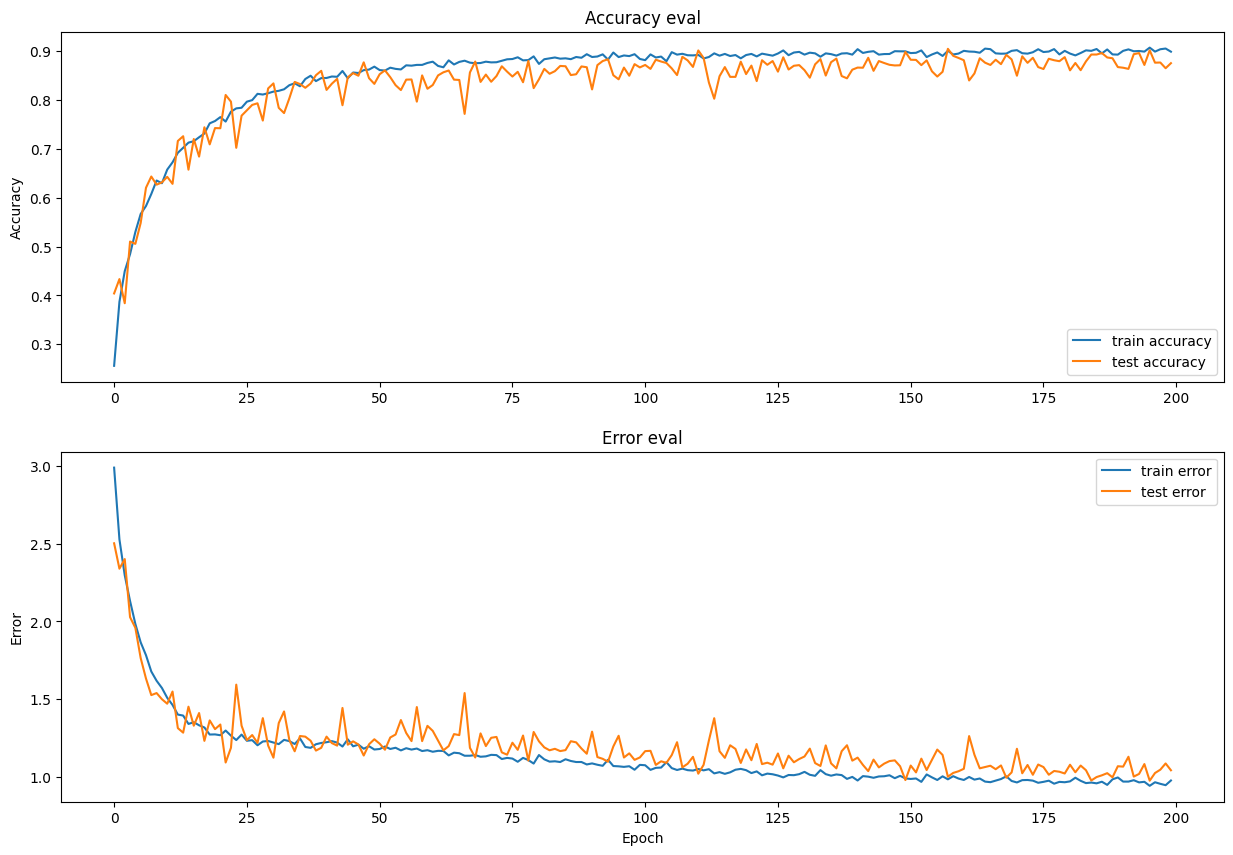

In [ ]:
def plot_history(history):
    fig, axs = plt.subplots(2, figsize=(15, 10))

    # Accuracy
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # Error
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

plot_history(history)


In [ ]:
model.save('/content/drive/MyDrive/GTZAN/genre_classification_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
